# SVM (Support Vector Machines)

In [1]:
# pip install plotly

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.graph_objects as go

from sklearn.gaussian_process.kernels import RBF
from sklearn import svm
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import learning_curve

Read in training data:

In [3]:
X_train = pd.read_csv('../data/train/X_train.csv')
y_train = np.ravel(pd.read_csv('../data/train/y_train.csv'))

In [4]:
def report(Y, pred):
    print('Confusion matrix: \n', confusion_matrix(Y, pred))
    print('\nClassification report: \n', classification_report(Y, pred, zero_division=True))

In [5]:
def learning_curves(estimator, X, Y, train_sizes, cv, scoring = "accuracy"):
    
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, X, Y, train_sizes = train_sizes, cv = cv, scoring = scoring)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training ' + scoring)
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation ' + scoring)

    plt.ylabel(scoring, fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()

Some parts of following function is partially copied from: https://community.plotly.com/

In [6]:
def show3D(X, Y, model):
#     if kernel == 'linear':
    z = lambda x,y: (-model.intercept_[0]-model.coef_[0][0]*x-model.coef_[0][1]*y) / model.coef_[0][2]
#     else:
#         z = lambda x, y: np.exp(-gamma * (np.array(X)**2).sum(1))
# #         z = lambda x,_: RBF(1.0).__call__(x)[0]
        
    xm, xM = X[:,0].min(), X[:, 0].max()
    ym, yM = X[:,1].min(), X[:, 1].max()
    x = np.linspace(xm, xM, 10)
    y = np.linspace(ym, yM, 10)
    x, y =np.meshgrid(x, y)

    fig = go.FigureWidget()
    fig.add_surface(x=x, y=y, z=z(x,y), showscale=False, colorscale = [[0, 'rgb(0,0,255)'], [0,
        'rgb(255,0,0)']])
    fig.add_scatter3d(x=X[Y==0,0], y=X[Y==0,1], z=X[Y==0,2], mode='markers', marker={'color': 'blue'})
    fig.add_scatter3d(x=X[Y==1,0], y=X[Y==1,1], z=X[Y==1,2], mode='markers', marker={'color': 'red'})
    fig.update_layout(width=800, height=800)
    fig.show()

### Model creation and training:

In [7]:
params = {
    "kernel" : ["linear","rbf"],
    "C" : [0.1, 0.5, 1, 5]
}

svm_grid = GridSearchCV(svm.SVC(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
svm_grid.fit(X_train, y_train)

print('Best accuracy : {:.3f}'.format(svm_grid.best_score_))
print('Best hyperparameters : {}\n'.format(svm_grid.best_params_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best accuracy : 0.933
Best hyperparameters : {'C': 5, 'kernel': 'linear'}



In [8]:
C = svm_grid.best_params_['C']
kernel = svm_grid.best_params_['kernel']

In [9]:
model = svm.SVC(C=C, kernel=kernel, degree=3, probability=True)
model.fit(X_train,y_train)

SVC(C=5, kernel='linear', probability=True)

### Prediction on training set:

In [10]:
y_train_pred = model.predict(X_train)
report(y_train, y_train_pred)

Confusion matrix: 
 [[178   0]
 [  0 223]]

Classification report: 
               precision    recall  f1-score   support

      Modern       1.00      1.00      1.00       178
 Renaissance       1.00      1.00      1.00       223

    accuracy                           1.00       401
   macro avg       1.00      1.00      1.00       401
weighted avg       1.00      1.00      1.00       401



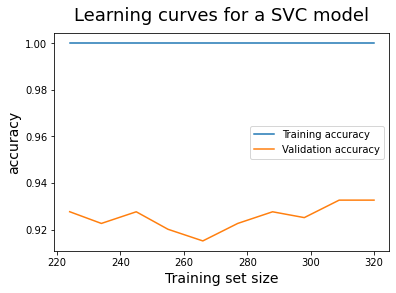

In [11]:
learning_curves(model, X_train, y_train, np.linspace(0.7, 1.0, 10), 5, scoring = "accuracy")

### Testing model:

Read in test data:

In [12]:
X_test = pd.read_csv('../data/test/X_test.csv')
y_test = np.ravel(pd.read_csv('../data/test/y_test.csv'))
# y_test

In [13]:
y_test_pred = model.predict(X_test)
report(y_test, y_test_pred)

Confusion matrix: 
 [[74  6]
 [ 1 91]]

Classification report: 
               precision    recall  f1-score   support

      Modern       0.99      0.93      0.95        80
 Renaissance       0.94      0.99      0.96        92

    accuracy                           0.96       172
   macro avg       0.96      0.96      0.96       172
weighted avg       0.96      0.96      0.96       172



#### Saving predictions and probablilities for model comparison:

In [14]:
pd.DataFrame(y_test_pred).to_csv('results/svm_pred.csv', index=False)
pd.DataFrame(model.predict_proba(X_test)[:,1]).to_csv('results/svm_prob.csv', index=False)

### ROC curve - for test and train data

In [36]:
Encoder = LabelEncoder()
y_train_encoded = Encoder.fit_transform(y_train)
y_test_encoded = Encoder.fit_transform(y_test)

In [37]:
#test data
y_score1 = model.predict_proba(X_test)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test_encoded, y_score1)
test_score = round(roc_auc_score(y_test_encoded, y_score1), 2)
#train data
y_score2 = model.predict_proba(X_train)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_train_encoded, y_score2)
val_score = round(roc_auc_score(y_train_encoded, y_score2), 2)

/home/milica/.local/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SVC was fitted without feature names



ValueError: X has 11576 features, but SVC is expecting 3 features as input.

In [ ]:
plt.subplots(1, figsize=(8,8))
plt.title('ROC curve - SVM')
#roc curve for test data
plt.plot(false_positive_rate1, true_positive_rate1, label="Test data AUC: " + str(test_score))
#roc curve for train data
plt.plot(false_positive_rate2, true_positive_rate2, label="Train data AUC: " + str(val_score))
plt.plot([0, 1], ls="--", color='gray')
plt.legend(loc='lower right')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [38]:
print(f'Number of support vector for each class: \n{model.n_support_}')
print(f'Index of instanced which are support vectors: \n{model.support_}')
print(f'Support vectors: \n {model.support_vectors_}')

Number of support vector for each class: 
[124 123]
Index of instanced which are support vectors: 
[  7  10  14  17  22  24  27  29  38  39  43  45  47  48  50  53  58  59
  62  65  68  76  80  84  87  95  96 110 111 115 116 118 121 122 127 128
 130 132 134 136 137 141 143 146 164 165 171 174 176 177 178 183 185 186
 190 195 198 200 201 202 206 208 209 210 218 222 224 227 229 239 240 243
 245 247 253 258 264 266 268 270 274 277 282 288 289 290 294 295 296 300
 301 305 307 308 309 311 317 319 322 326 327 328 329 330 334 335 340 343
 351 352 355 360 361 362 365 368 375 382 385 386 388 390 391 399   1   2
   4   5   8  13  16  18  19  21  25  30  31  33  34  35  36  37  44  52
  54  56  66  67  70  75  79  82  89  90  93 100 102 103 104 114 123 124
 135 138 145 147 148 150 153 154 159 160 161 170 173 180 181 187 193 194
 197 203 205 207 211 215 216 217 219 220 221 223 225 228 230 231 233 241
 246 256 257 260 262 265 267 272 273 276 278 281 284 285 291 298 299 302
 312 313 314 323 332 333 

In [41]:
# pca = PCA(n_components=3)
# reduced_data = pca.fit_transform(X_test)

svd = TruncatedSVD(n_components=3)
reduced_data = svd.fit_transform(X_test)

In [42]:
show3D(reduced_data, y_test_encoded, model)

## SVM with SVD

In [21]:
# pca = PCA(n_components=3)
# reduced_data = pca.fit_transform(X_train)

svd = TruncatedSVD(n_components=3)
reduced_data = svd.fit_transform(X_train)

In [22]:
params = {
    "kernel" : ["linear"],
    "C" : [0.1, 0.5, 1, 5]
}

svm_grid = GridSearchCV(svm.SVC(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
svm_grid.fit(reduced_data, y_train)

print('Best accuracy : {:.3f}'.format(svm_grid.best_score_))
print('Best hyperparameters : {}\n'.format(svm_grid.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best accuracy : 0.771
Best hyperparameters : {'C': 5, 'kernel': 'linear'}



In [23]:
C = svm_grid.best_params_['C']
kernel = svm_grid.best_params_['kernel']

In [24]:
model = svm.SVC(C=C, kernel=kernel, degree=3, probability=True)
model.fit(reduced_data,y_train)

SVC(C=5, kernel='linear', probability=True)

In [25]:
y_train_pred = model.predict(reduced_data)
report(y_train, y_train_pred)

Confusion matrix: 
 [[ 99  79]
 [ 12 211]]

Classification report: 
               precision    recall  f1-score   support

      Modern       0.89      0.56      0.69       178
 Renaissance       0.73      0.95      0.82       223

    accuracy                           0.77       401
   macro avg       0.81      0.75      0.75       401
weighted avg       0.80      0.77      0.76       401



In [26]:
show3D(reduced_data, y_train_encoded, model)

In [30]:
# pca = PCA(n_components=3)
reduced_data = svd.fit_transform(X_test)

In [31]:
y_test_pred = model.predict(reduced_data)
report(y_test, y_test_pred)

Confusion matrix: 
 [[51 29]
 [ 1 91]]

Classification report: 
               precision    recall  f1-score   support

      Modern       0.98      0.64      0.77        80
 Renaissance       0.76      0.99      0.86        92

    accuracy                           0.83       172
   macro avg       0.87      0.81      0.82       172
weighted avg       0.86      0.83      0.82       172



In [32]:
show3D(reduced_data, y_test_encoded, model)